<a href="https://colab.research.google.com/github/nguyenhuy-vn/Finger-identification-based-on-capacitives-touch-screen/blob/main/Resnet_18_for_classification_left_thumb_and_right_thumb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Connect to google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import cv2
from tensorflow.keras import datasets, models, layers

### Load data

In [3]:
X_train = np.load('/content/drive/MyDrive/data for 2/X_train.npy')
X_test = np.load('/content/drive/MyDrive/data for 2/X_test.npy')
X_val = np.load('/content/drive/MyDrive/data for 2/X_val.npy')
Y_train = np.load('/content/drive/MyDrive/data for 2/Y_train.npy')
Y_test = np.load('/content/drive/MyDrive/data for 2/Y_test.npy')
Y_val = np.load('/content/drive/MyDrive/data for 2/Y_val.npy')
label = np.load('/content/drive/MyDrive/data for 2/label.npy')

### Check if have any missing data

In [4]:
X_train.shape, X_test.shape, X_val.shape, Y_train.shape, Y_test.shape, Y_val.shape

((61122, 32, 32),
 (19168, 32, 32),
 (15281, 32, 32),
 (61122, 2),
 (19168, 2),
 (15281, 2))

In [5]:
X_train[0]

array([[0.02745098, 0.02745098, 0.02745098, ..., 0.04313726, 0.04313726,
        0.04313726],
       [0.02745098, 0.02745098, 0.02745098, ..., 0.04313726, 0.04313726,
        0.04313726],
       [0.02745098, 0.02745098, 0.02745098, ..., 0.04313726, 0.04313726,
        0.04313726],
       ...,
       [0.05882353, 0.05882353, 0.05882353, ..., 0.07058824, 0.07058824,
        0.07058824],
       [0.05882353, 0.05882353, 0.05882353, ..., 0.07058824, 0.07058824,
        0.07058824],
       [0.05882353, 0.05882353, 0.05882353, ..., 0.07058824, 0.07058824,
        0.07058824]], dtype=float32)

In [6]:
X_val[0]

array([[0.00784314, 0.00784314, 0.00784314, ..., 0.02745098, 0.02745098,
        0.02745098],
       [0.00784314, 0.00784314, 0.00784314, ..., 0.02745098, 0.02745098,
        0.02745098],
       [0.00784314, 0.00784314, 0.00784314, ..., 0.02745098, 0.02745098,
        0.02745098],
       ...,
       [0.01568628, 0.01568628, 0.01568628, ..., 0.07058824, 0.07058824,
        0.07058824],
       [0.01568628, 0.01568628, 0.01568628, ..., 0.07058824, 0.07058824,
        0.07058824],
       [0.01568628, 0.01568628, 0.01568628, ..., 0.07058824, 0.07058824,
        0.07058824]], dtype=float32)

In [7]:
Y_train[0]

array([0., 1.])

### Model and Train

In [8]:
X_train = X_train.reshape(X_train.shape[0], 32, 32, 1)
X_test = X_test.reshape(X_test.shape[0], 32, 32, 1)
X_val = X_val.reshape(X_val.shape[0],32,32,1)

In [9]:
from keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(horizontal_flip=True, width_shift_range=0.05,
                             height_shift_range=0.05)
aug.fit(X_train)

In [10]:
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add
from keras.models import Sequential
from keras.models import Model
import tensorflow as tf


class ResnetBlock(Model):
    """
    A standard resnet block.
    """

    def __init__(self, channels: int, down_sample=False):
        """
        channels: same as number of convolution kernels
        """
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        # use He initialization, instead of Xavier (a.k.a 'glorot_uniform' in Keras), as suggested in [2]
        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            # perform down sampling using stride of 2, according to [1].
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out


class ResNet18(Model):

    def __init__(self, num_classes, **kwargs):
        """
            num_classes: number of classes in specific classification task.
        """
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (7, 7), strides=2,
                             padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="softmax")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out

In [11]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [13]:
model = ResNet18(2)
model.build(input_shape = (None, 32, 32, 1))
#use categorical_crossentropy since the label is one-hot encoded
from keras.optimizers import SGD
# opt = SGD(learning_rate=0.1,momentum=0.9,decay = 1e-04) #parameters suggested by He [1]
model.compile(optimizer = "adam",loss='categorical_crossentropy', metrics=["accuracy", f1_m, precision_m, recall_m])
model.summary()

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "res_net18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  3200      
                                                                 
 batch_normalization (Batch  multiple                  256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  multiple                  0         
 D)                                                              
                                                                 
 resnet_block (ResnetBlock)  multiple                  74368     
                                                                 
 resnet_block_1 (ResnetBloc  multiple               

In [14]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(patience= 8, restore_best_weights=True, monitor="val_acc")
#I did not use cross validation, so the validate performance is not accurate.
STEPS = len(X_train) / 256
history = model.fit(aug.flow(X_train,Y_train,batch_size = 256), steps_per_epoch=STEPS, batch_size = 256, epochs= 50, validation_data=(X_val, Y_val),callbacks=[es])

Epoch 1/50
239/238 [==============================] - ETA: 0s - loss: 0.5745 - accuracy: 0.7251 - f1_m: 0.7252 - precision_m: 0.7252 - recall_m: 0.7252

238/238 [==============================] - 49s 110ms/step - loss: 0.5745 - accuracy: 0.7251 - f1_m: 0.7252 - precision_m: 0.7252 - recall_m: 0.7252 - val_loss: 1.5369 - val_accuracy: 0.5393 - val_f1_m: 0.5391 - val_precision_m: 0.5391 - val_recall_m: 0.5391
Epoch 2/50
239/238 [==============================] - ETA: 0s - loss: 0.3484 - accuracy: 0.8443 - f1_m: 0.8442 - precision_m: 0.8442 - recall_m: 0.8442

238/238 [==============================] - 22s 93ms/step - loss: 0.3484 - accuracy: 0.8443 - f1_m: 0.8442 - precision_m: 0.8442 - recall_m: 0.8442 - val_loss: 0.9191 - val_accuracy: 0.6846 - val_f1_m: 0.6845 - val_precision_m: 0.6845 - val_recall_m: 0.6845
Epoch 3/50
239/238 [==============================] - ETA: 0s - loss: 0.2947 - accuracy: 0.8694 - f1_m: 0.8694 - precision_m: 0.8694 - recall_m: 0.8694

238/238 [==============================] - 27s 111ms/step - loss: 0.2947 - accuracy: 0.8694 - f1_m: 0.8694 - precision_m: 0.8694 - recall_m: 0.8694 - val_loss: 0.3002 - val_accuracy: 0.8732 - val_f1_m: 0.8731 - val_precision_m: 0.8731 - val_recall_m: 0.8731
Epoch 4/50
239/238 [==============================] - ETA: 0s - loss: 0.2702 - accuracy: 0.8817 - f1_m: 0.8817 - precision_m: 0.8817 - recall_m: 0.8817

238/238 [==============================] - 23s 94ms/step - loss: 0.2702 - accuracy: 0.8817 - f1_m: 0.8817 - precision_m: 0.8817 - recall_m: 0.8817 - val_loss: 0.3261 - val_accuracy: 0.8704 - val_f1_m: 0.8704 - val_precision_m: 0.8704 - val_recall_m: 0.8704
Epoch 5/50
239/238 [==============================] - ETA: 0s - loss: 0.2504 - accuracy: 0.8911 - f1_m: 0.8910 - precision_m: 0.8910 - recall_m: 0.8910

238/238 [==============================] - 22s 94ms/step - loss: 0.2504 - accuracy: 0.8911 - f1_m: 0.8910 - precision_m: 0.8910 - recall_m: 0.8910 - val_loss: 0.3129 - val_accuracy: 0.8685 - val_f1_m: 0.8683 - val_precision_m: 0.8683 - val_recall_m: 0.8683
Epoch 6/50
239/238 [==============================] - ETA: 0s - loss: 0.2391 - accuracy: 0.8962 - f1_m: 0.8962 - precision_m: 0.8962 - recall_m: 0.8962

238/238 [==============================] - 22s 93ms/step - loss: 0.2391 - accuracy: 0.8962 - f1_m: 0.8962 - precision_m: 0.8962 - recall_m: 0.8962 - val_loss: 0.2824 - val_accuracy: 0.8803 - val_f1_m: 0.8803 - val_precision_m: 0.8803 - val_recall_m: 0.8803
Epoch 7/50
239/238 [==============================] - ETA: 0s - loss: 0.2241 - accuracy: 0.9047 - f1_m: 0.9047 - precision_m: 0.9047 - recall_m: 0.9047

238/238 [==============================] - 23s 95ms/step - loss: 0.2241 - accuracy: 0.9047 - f1_m: 0.9047 - precision_m: 0.9047 - recall_m: 0.9047 - val_loss: 0.2531 - val_accuracy: 0.8959 - val_f1_m: 0.8959 - val_precision_m: 0.8959 - val_recall_m: 0.8959
Epoch 8/50
239/238 [==============================] - ETA: 0s - loss: 0.2193 - accuracy: 0.9064 - f1_m: 0.9064 - precision_m: 0.9064 - recall_m: 0.9064

238/238 [==============================] - 21s 88ms/step - loss: 0.2193 - accuracy: 0.9064 - f1_m: 0.9064 - precision_m: 0.9064 - recall_m: 0.9064 - val_loss: 0.2913 - val_accuracy: 0.8848 - val_f1_m: 0.8848 - val_precision_m: 0.8848 - val_recall_m: 0.8848
Epoch 9/50
239/238 [==============================] - ETA: 0s - loss: 0.2013 - accuracy: 0.9145 - f1_m: 0.9145 - precision_m: 0.9145 - recall_m: 0.9145

238/238 [==============================] - 22s 91ms/step - loss: 0.2013 - accuracy: 0.9145 - f1_m: 0.9145 - precision_m: 0.9145 - recall_m: 0.9145 - val_loss: 0.2920 - val_accuracy: 0.8873 - val_f1_m: 0.8873 - val_precision_m: 0.8873 - val_recall_m: 0.8873
Epoch 10/50
239/238 [==============================] - ETA: 0s - loss: 0.1953 - accuracy: 0.9167 - f1_m: 0.9167 - precision_m: 0.9167 - recall_m: 0.9167

238/238 [==============================] - 22s 93ms/step - loss: 0.1953 - accuracy: 0.9167 - f1_m: 0.9167 - precision_m: 0.9167 - recall_m: 0.9167 - val_loss: 0.2705 - val_accuracy: 0.8914 - val_f1_m: 0.8913 - val_precision_m: 0.8913 - val_recall_m: 0.8913
Epoch 11/50
239/238 [==============================] - ETA: 0s - loss: 0.1846 - accuracy: 0.9226 - f1_m: 0.9226 - precision_m: 0.9226 - recall_m: 0.9226

238/238 [==============================] - 21s 87ms/step - loss: 0.1846 - accuracy: 0.9226 - f1_m: 0.9226 - precision_m: 0.9226 - recall_m: 0.9226 - val_loss: 0.2267 - val_accuracy: 0.9070 - val_f1_m: 0.9069 - val_precision_m: 0.9069 - val_recall_m: 0.9069
Epoch 12/50
239/238 [==============================] - ETA: 0s - loss: 0.1791 - accuracy: 0.9244 - f1_m: 0.9244 - precision_m: 0.9244 - recall_m: 0.9244

238/238 [==============================] - 21s 88ms/step - loss: 0.1791 - accuracy: 0.9244 - f1_m: 0.9244 - precision_m: 0.9244 - recall_m: 0.9244 - val_loss: 0.2114 - val_accuracy: 0.9181 - val_f1_m: 0.9182 - val_precision_m: 0.9182 - val_recall_m: 0.9182
Epoch 13/50
239/238 [==============================] - ETA: 0s - loss: 0.1736 - accuracy: 0.9271 - f1_m: 0.9271 - precision_m: 0.9271 - recall_m: 0.9271

238/238 [==============================] - 22s 92ms/step - loss: 0.1736 - accuracy: 0.9271 - f1_m: 0.9271 - precision_m: 0.9271 - recall_m: 0.9271 - val_loss: 0.5949 - val_accuracy: 0.8137 - val_f1_m: 0.8139 - val_precision_m: 0.8139 - val_recall_m: 0.8139
Epoch 14/50
239/238 [==============================] - ETA: 0s - loss: 0.1688 - accuracy: 0.9301 - f1_m: 0.9301 - precision_m: 0.9301 - recall_m: 0.9301

238/238 [==============================] - 22s 90ms/step - loss: 0.1688 - accuracy: 0.9301 - f1_m: 0.9301 - precision_m: 0.9301 - recall_m: 0.9301 - val_loss: 0.2204 - val_accuracy: 0.9084 - val_f1_m: 0.9084 - val_precision_m: 0.9084 - val_recall_m: 0.9084
Epoch 15/50
239/238 [==============================] - ETA: 0s - loss: 0.1599 - accuracy: 0.9333 - f1_m: 0.9333 - precision_m: 0.9333 - recall_m: 0.9333

238/238 [==============================] - 21s 89ms/step - loss: 0.1599 - accuracy: 0.9333 - f1_m: 0.9333 - precision_m: 0.9333 - recall_m: 0.9333 - val_loss: 0.2128 - val_accuracy: 0.9191 - val_f1_m: 0.9191 - val_precision_m: 0.9191 - val_recall_m: 0.9191
Epoch 16/50
239/238 [==============================] - ETA: 0s - loss: 0.1559 - accuracy: 0.9359 - f1_m: 0.9359 - precision_m: 0.9359 - recall_m: 0.9359

238/238 [==============================] - 22s 93ms/step - loss: 0.1559 - accuracy: 0.9359 - f1_m: 0.9359 - precision_m: 0.9359 - recall_m: 0.9359 - val_loss: 0.1957 - val_accuracy: 0.9233 - val_f1_m: 0.9234 - val_precision_m: 0.9234 - val_recall_m: 0.9234
Epoch 17/50
239/238 [==============================] - ETA: 0s - loss: 0.1492 - accuracy: 0.9391 - f1_m: 0.9391 - precision_m: 0.9391 - recall_m: 0.9391

238/238 [==============================] - 22s 90ms/step - loss: 0.1492 - accuracy: 0.9391 - f1_m: 0.9391 - precision_m: 0.9391 - recall_m: 0.9391 - val_loss: 0.2488 - val_accuracy: 0.9027 - val_f1_m: 0.9029 - val_precision_m: 0.9029 - val_recall_m: 0.9029
Epoch 18/50
239/238 [==============================] - ETA: 0s - loss: 0.1458 - accuracy: 0.9398 - f1_m: 0.9399 - precision_m: 0.9399 - recall_m: 0.9399

238/238 [==============================] - 22s 93ms/step - loss: 0.1458 - accuracy: 0.9398 - f1_m: 0.9399 - precision_m: 0.9399 - recall_m: 0.9399 - val_loss: 0.1856 - val_accuracy: 0.9244 - val_f1_m: 0.9244 - val_precision_m: 0.9244 - val_recall_m: 0.9244
Epoch 19/50
239/238 [==============================] - ETA: 0s - loss: 0.1408 - accuracy: 0.9425 - f1_m: 0.9424 - precision_m: 0.9424 - recall_m: 0.9424

238/238 [==============================] - 23s 94ms/step - loss: 0.1408 - accuracy: 0.9425 - f1_m: 0.9424 - precision_m: 0.9424 - recall_m: 0.9424 - val_loss: 0.2228 - val_accuracy: 0.9139 - val_f1_m: 0.9141 - val_precision_m: 0.9141 - val_recall_m: 0.9141
Epoch 20/50
239/238 [==============================] - ETA: 0s - loss: 0.1354 - accuracy: 0.9449 - f1_m: 0.9449 - precision_m: 0.9449 - recall_m: 0.9449

238/238 [==============================] - 22s 93ms/step - loss: 0.1354 - accuracy: 0.9449 - f1_m: 0.9449 - precision_m: 0.9449 - recall_m: 0.9449 - val_loss: 0.2173 - val_accuracy: 0.9124 - val_f1_m: 0.9124 - val_precision_m: 0.9124 - val_recall_m: 0.9124
Epoch 21/50
239/238 [==============================] - ETA: 0s - loss: 0.1315 - accuracy: 0.9456 - f1_m: 0.9456 - precision_m: 0.9456 - recall_m: 0.9456

238/238 [==============================] - 21s 88ms/step - loss: 0.1315 - accuracy: 0.9456 - f1_m: 0.9456 - precision_m: 0.9456 - recall_m: 0.9456 - val_loss: 0.2153 - val_accuracy: 0.9140 - val_f1_m: 0.9141 - val_precision_m: 0.9141 - val_recall_m: 0.9141
Epoch 22/50
239/238 [==============================] - ETA: 0s - loss: 0.1268 - accuracy: 0.9489 - f1_m: 0.9489 - precision_m: 0.9489 - recall_m: 0.9489

238/238 [==============================] - 22s 93ms/step - loss: 0.1268 - accuracy: 0.9489 - f1_m: 0.9489 - precision_m: 0.9489 - recall_m: 0.9489 - val_loss: 0.3435 - val_accuracy: 0.8827 - val_f1_m: 0.8828 - val_precision_m: 0.8828 - val_recall_m: 0.8828
Epoch 23/50
239/238 [==============================] - ETA: 0s - loss: 0.1209 - accuracy: 0.9514 - f1_m: 0.9514 - precision_m: 0.9514 - recall_m: 0.9514

238/238 [==============================] - 21s 88ms/step - loss: 0.1209 - accuracy: 0.9514 - f1_m: 0.9514 - precision_m: 0.9514 - recall_m: 0.9514 - val_loss: 0.2205 - val_accuracy: 0.9179 - val_f1_m: 0.9180 - val_precision_m: 0.9180 - val_recall_m: 0.9180
Epoch 24/50
239/238 [==============================] - ETA: 0s - loss: 0.1200 - accuracy: 0.9508 - f1_m: 0.9507 - precision_m: 0.9507 - recall_m: 0.9507

238/238 [==============================] - 23s 94ms/step - loss: 0.1200 - accuracy: 0.9508 - f1_m: 0.9507 - precision_m: 0.9507 - recall_m: 0.9507 - val_loss: 0.2563 - val_accuracy: 0.9184 - val_f1_m: 0.9185 - val_precision_m: 0.9185 - val_recall_m: 0.9185
Epoch 25/50
239/238 [==============================] - ETA: 0s - loss: 0.1157 - accuracy: 0.9537 - f1_m: 0.9536 - precision_m: 0.9536 - recall_m: 0.9536

238/238 [==============================] - 21s 88ms/step - loss: 0.1157 - accuracy: 0.9537 - f1_m: 0.9536 - precision_m: 0.9536 - recall_m: 0.9536 - val_loss: 0.2101 - val_accuracy: 0.9237 - val_f1_m: 0.9237 - val_precision_m: 0.9237 - val_recall_m: 0.9237
Epoch 26/50
239/238 [==============================] - ETA: 0s - loss: 0.1115 - accuracy: 0.9553 - f1_m: 0.9553 - precision_m: 0.9553 - recall_m: 0.9553

238/238 [==============================] - 22s 94ms/step - loss: 0.1115 - accuracy: 0.9553 - f1_m: 0.9553 - precision_m: 0.9553 - recall_m: 0.9553 - val_loss: 0.1778 - val_accuracy: 0.9328 - val_f1_m: 0.9327 - val_precision_m: 0.9327 - val_recall_m: 0.9327
Epoch 27/50
239/238 [==============================] - ETA: 0s - loss: 0.1042 - accuracy: 0.9580 - f1_m: 0.9580 - precision_m: 0.9580 - recall_m: 0.9580

238/238 [==============================] - 22s 93ms/step - loss: 0.1042 - accuracy: 0.9580 - f1_m: 0.9580 - precision_m: 0.9580 - recall_m: 0.9580 - val_loss: 0.2317 - val_accuracy: 0.9140 - val_f1_m: 0.9140 - val_precision_m: 0.9140 - val_recall_m: 0.9140
Epoch 28/50
239/238 [==============================] - ETA: 0s - loss: 0.1078 - accuracy: 0.9572 - f1_m: 0.9572 - precision_m: 0.9572 - recall_m: 0.9572

238/238 [==============================] - 22s 90ms/step - loss: 0.1078 - accuracy: 0.9572 - f1_m: 0.9572 - precision_m: 0.9572 - recall_m: 0.9572 - val_loss: 0.1631 - val_accuracy: 0.9379 - val_f1_m: 0.9379 - val_precision_m: 0.9379 - val_recall_m: 0.9379
Epoch 29/50
239/238 [==============================] - ETA: 0s - loss: 0.0994 - accuracy: 0.9596 - f1_m: 0.9596 - precision_m: 0.9596 - recall_m: 0.9596

238/238 [==============================] - 23s 94ms/step - loss: 0.0994 - accuracy: 0.9596 - f1_m: 0.9596 - precision_m: 0.9596 - recall_m: 0.9596 - val_loss: 0.2520 - val_accuracy: 0.9050 - val_f1_m: 0.9051 - val_precision_m: 0.9051 - val_recall_m: 0.9051
Epoch 30/50
239/238 [==============================] - ETA: 0s - loss: 0.0978 - accuracy: 0.9610 - f1_m: 0.9610 - precision_m: 0.9610 - recall_m: 0.9610

238/238 [==============================] - 23s 95ms/step - loss: 0.0978 - accuracy: 0.9610 - f1_m: 0.9610 - precision_m: 0.9610 - recall_m: 0.9610 - val_loss: 0.1602 - val_accuracy: 0.9430 - val_f1_m: 0.9431 - val_precision_m: 0.9431 - val_recall_m: 0.9431
Epoch 31/50
239/238 [==============================] - ETA: 0s - loss: 0.0919 - accuracy: 0.9643 - f1_m: 0.9643 - precision_m: 0.9643 - recall_m: 0.9643

238/238 [==============================] - 22s 93ms/step - loss: 0.0919 - accuracy: 0.9643 - f1_m: 0.9643 - precision_m: 0.9643 - recall_m: 0.9643 - val_loss: 0.1581 - val_accuracy: 0.9404 - val_f1_m: 0.9404 - val_precision_m: 0.9404 - val_recall_m: 0.9404
Epoch 32/50
239/238 [==============================] - ETA: 0s - loss: 0.0902 - accuracy: 0.9642 - f1_m: 0.9642 - precision_m: 0.9642 - recall_m: 0.9642

238/238 [==============================] - 21s 89ms/step - loss: 0.0902 - accuracy: 0.9642 - f1_m: 0.9642 - precision_m: 0.9642 - recall_m: 0.9642 - val_loss: 0.1619 - val_accuracy: 0.9416 - val_f1_m: 0.9417 - val_precision_m: 0.9417 - val_recall_m: 0.9417
Epoch 33/50
239/238 [==============================] - ETA: 0s - loss: 0.0858 - accuracy: 0.9662 - f1_m: 0.9662 - precision_m: 0.9662 - recall_m: 0.9662

238/238 [==============================] - 23s 94ms/step - loss: 0.0858 - accuracy: 0.9662 - f1_m: 0.9662 - precision_m: 0.9662 - recall_m: 0.9662 - val_loss: 0.2195 - val_accuracy: 0.9291 - val_f1_m: 0.9291 - val_precision_m: 0.9291 - val_recall_m: 0.9291
Epoch 34/50
239/238 [==============================] - ETA: 0s - loss: 0.0859 - accuracy: 0.9661 - f1_m: 0.9661 - precision_m: 0.9661 - recall_m: 0.9661

238/238 [==============================] - 22s 91ms/step - loss: 0.0859 - accuracy: 0.9661 - f1_m: 0.9661 - precision_m: 0.9661 - recall_m: 0.9661 - val_loss: 0.2794 - val_accuracy: 0.9136 - val_f1_m: 0.9136 - val_precision_m: 0.9136 - val_recall_m: 0.9136
Epoch 35/50
239/238 [==============================] - ETA: 0s - loss: 0.0804 - accuracy: 0.9681 - f1_m: 0.9681 - precision_m: 0.9681 - recall_m: 0.9681

238/238 [==============================] - 22s 93ms/step - loss: 0.0804 - accuracy: 0.9681 - f1_m: 0.9681 - precision_m: 0.9681 - recall_m: 0.9681 - val_loss: 0.1869 - val_accuracy: 0.9328 - val_f1_m: 0.9328 - val_precision_m: 0.9328 - val_recall_m: 0.9328
Epoch 36/50
239/238 [==============================] - ETA: 0s - loss: 0.0771 - accuracy: 0.9700 - f1_m: 0.9700 - precision_m: 0.9700 - recall_m: 0.9700

238/238 [==============================] - 21s 88ms/step - loss: 0.0771 - accuracy: 0.9700 - f1_m: 0.9700 - precision_m: 0.9700 - recall_m: 0.9700 - val_loss: 0.1616 - val_accuracy: 0.9445 - val_f1_m: 0.9444 - val_precision_m: 0.9444 - val_recall_m: 0.9444
Epoch 37/50
239/238 [==============================] - ETA: 0s - loss: 0.0766 - accuracy: 0.9698 - f1_m: 0.9698 - precision_m: 0.9698 - recall_m: 0.9698

238/238 [==============================] - 22s 94ms/step - loss: 0.0766 - accuracy: 0.9698 - f1_m: 0.9698 - precision_m: 0.9698 - recall_m: 0.9698 - val_loss: 0.1685 - val_accuracy: 0.9403 - val_f1_m: 0.9404 - val_precision_m: 0.9404 - val_recall_m: 0.9404
Epoch 38/50
239/238 [==============================] - ETA: 0s - loss: 0.0761 - accuracy: 0.9704 - f1_m: 0.9704 - precision_m: 0.9704 - recall_m: 0.9704

238/238 [==============================] - 22s 92ms/step - loss: 0.0761 - accuracy: 0.9704 - f1_m: 0.9704 - precision_m: 0.9704 - recall_m: 0.9704 - val_loss: 0.1959 - val_accuracy: 0.9320 - val_f1_m: 0.9322 - val_precision_m: 0.9322 - val_recall_m: 0.9322
Epoch 39/50
239/238 [==============================] - ETA: 0s - loss: 0.0708 - accuracy: 0.9721 - f1_m: 0.9721 - precision_m: 0.9721 - recall_m: 0.9721

238/238 [==============================] - 22s 90ms/step - loss: 0.0708 - accuracy: 0.9721 - f1_m: 0.9721 - precision_m: 0.9721 - recall_m: 0.9721 - val_loss: 0.1632 - val_accuracy: 0.9433 - val_f1_m: 0.9433 - val_precision_m: 0.9433 - val_recall_m: 0.9433
Epoch 40/50
239/238 [==============================] - ETA: 0s - loss: 0.0636 - accuracy: 0.9751 - f1_m: 0.9751 - precision_m: 0.9751 - recall_m: 0.9751

238/238 [==============================] - 26s 108ms/step - loss: 0.0636 - accuracy: 0.9751 - f1_m: 0.9751 - precision_m: 0.9751 - recall_m: 0.9751 - val_loss: 0.1674 - val_accuracy: 0.9435 - val_f1_m: 0.9435 - val_precision_m: 0.9435 - val_recall_m: 0.9435
Epoch 41/50
239/238 [==============================] - ETA: 0s - loss: 0.0685 - accuracy: 0.9736 - f1_m: 0.9736 - precision_m: 0.9736 - recall_m: 0.9736

238/238 [==============================] - 22s 91ms/step - loss: 0.0685 - accuracy: 0.9736 - f1_m: 0.9736 - precision_m: 0.9736 - recall_m: 0.9736 - val_loss: 0.1817 - val_accuracy: 0.9401 - val_f1_m: 0.9400 - val_precision_m: 0.9400 - val_recall_m: 0.9400
Epoch 42/50
239/238 [==============================] - ETA: 0s - loss: 0.0637 - accuracy: 0.9755 - f1_m: 0.9755 - precision_m: 0.9755 - recall_m: 0.9755

238/238 [==============================] - 22s 91ms/step - loss: 0.0637 - accuracy: 0.9755 - f1_m: 0.9755 - precision_m: 0.9755 - recall_m: 0.9755 - val_loss: 0.1809 - val_accuracy: 0.9408 - val_f1_m: 0.9406 - val_precision_m: 0.9406 - val_recall_m: 0.9406
Epoch 43/50
239/238 [==============================] - ETA: 0s - loss: 0.0617 - accuracy: 0.9761 - f1_m: 0.9761 - precision_m: 0.9761 - recall_m: 0.9761

238/238 [==============================] - 24s 99ms/step - loss: 0.0617 - accuracy: 0.9761 - f1_m: 0.9761 - precision_m: 0.9761 - recall_m: 0.9761 - val_loss: 0.1809 - val_accuracy: 0.9411 - val_f1_m: 0.9412 - val_precision_m: 0.9412 - val_recall_m: 0.9412
Epoch 44/50
239/238 [==============================] - ETA: 0s - loss: 0.0598 - accuracy: 0.9767 - f1_m: 0.9767 - precision_m: 0.9767 - recall_m: 0.9767

238/238 [==============================] - 23s 95ms/step - loss: 0.0598 - accuracy: 0.9767 - f1_m: 0.9767 - precision_m: 0.9767 - recall_m: 0.9767 - val_loss: 0.1805 - val_accuracy: 0.9399 - val_f1_m: 0.9398 - val_precision_m: 0.9398 - val_recall_m: 0.9398
Epoch 45/50
239/238 [==============================] - ETA: 0s - loss: 0.0557 - accuracy: 0.9785 - f1_m: 0.9785 - precision_m: 0.9785 - recall_m: 0.9785

238/238 [==============================] - 21s 88ms/step - loss: 0.0557 - accuracy: 0.9785 - f1_m: 0.9785 - precision_m: 0.9785 - recall_m: 0.9785 - val_loss: 0.1727 - val_accuracy: 0.9425 - val_f1_m: 0.9425 - val_precision_m: 0.9425 - val_recall_m: 0.9425
Epoch 46/50
239/238 [==============================] - ETA: 0s - loss: 0.0522 - accuracy: 0.9803 - f1_m: 0.9803 - precision_m: 0.9803 - recall_m: 0.9803

238/238 [==============================] - 22s 93ms/step - loss: 0.0522 - accuracy: 0.9803 - f1_m: 0.9803 - precision_m: 0.9803 - recall_m: 0.9803 - val_loss: 0.1627 - val_accuracy: 0.9468 - val_f1_m: 0.9469 - val_precision_m: 0.9469 - val_recall_m: 0.9469
Epoch 47/50
239/238 [==============================] - ETA: 0s - loss: 0.0537 - accuracy: 0.9795 - f1_m: 0.9795 - precision_m: 0.9795 - recall_m: 0.9795

238/238 [==============================] - 23s 95ms/step - loss: 0.0537 - accuracy: 0.9795 - f1_m: 0.9795 - precision_m: 0.9795 - recall_m: 0.9795 - val_loss: 0.1673 - val_accuracy: 0.9464 - val_f1_m: 0.9464 - val_precision_m: 0.9464 - val_recall_m: 0.9464
Epoch 48/50
239/238 [==============================] - ETA: 0s - loss: 0.0508 - accuracy: 0.9806 - f1_m: 0.9806 - precision_m: 0.9806 - recall_m: 0.9806

238/238 [==============================] - 21s 89ms/step - loss: 0.0508 - accuracy: 0.9806 - f1_m: 0.9806 - precision_m: 0.9806 - recall_m: 0.9806 - val_loss: 0.1610 - val_accuracy: 0.9462 - val_f1_m: 0.9463 - val_precision_m: 0.9463 - val_recall_m: 0.9463
Epoch 49/50
239/238 [==============================] - ETA: 0s - loss: 0.0503 - accuracy: 0.9815 - f1_m: 0.9815 - precision_m: 0.9815 - recall_m: 0.9815

238/238 [==============================] - 22s 93ms/step - loss: 0.0503 - accuracy: 0.9815 - f1_m: 0.9815 - precision_m: 0.9815 - recall_m: 0.9815 - val_loss: 0.1626 - val_accuracy: 0.9488 - val_f1_m: 0.9489 - val_precision_m: 0.9489 - val_recall_m: 0.9489
Epoch 50/50
239/238 [==============================] - ETA: 0s - loss: 0.0471 - accuracy: 0.9817 - f1_m: 0.9817 - precision_m: 0.9817 - recall_m: 0.9817

238/238 [==============================] - 23s 94ms/step - loss: 0.0471 - accuracy: 0.9817 - f1_m: 0.9817 - precision_m: 0.9817 - recall_m: 0.9817 - val_loss: 0.1966 - val_accuracy: 0.9440 - val_f1_m: 0.9440 - val_precision_m: 0.9440 - val_recall_m: 0.9440


dict_keys(['loss', 'accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m'])


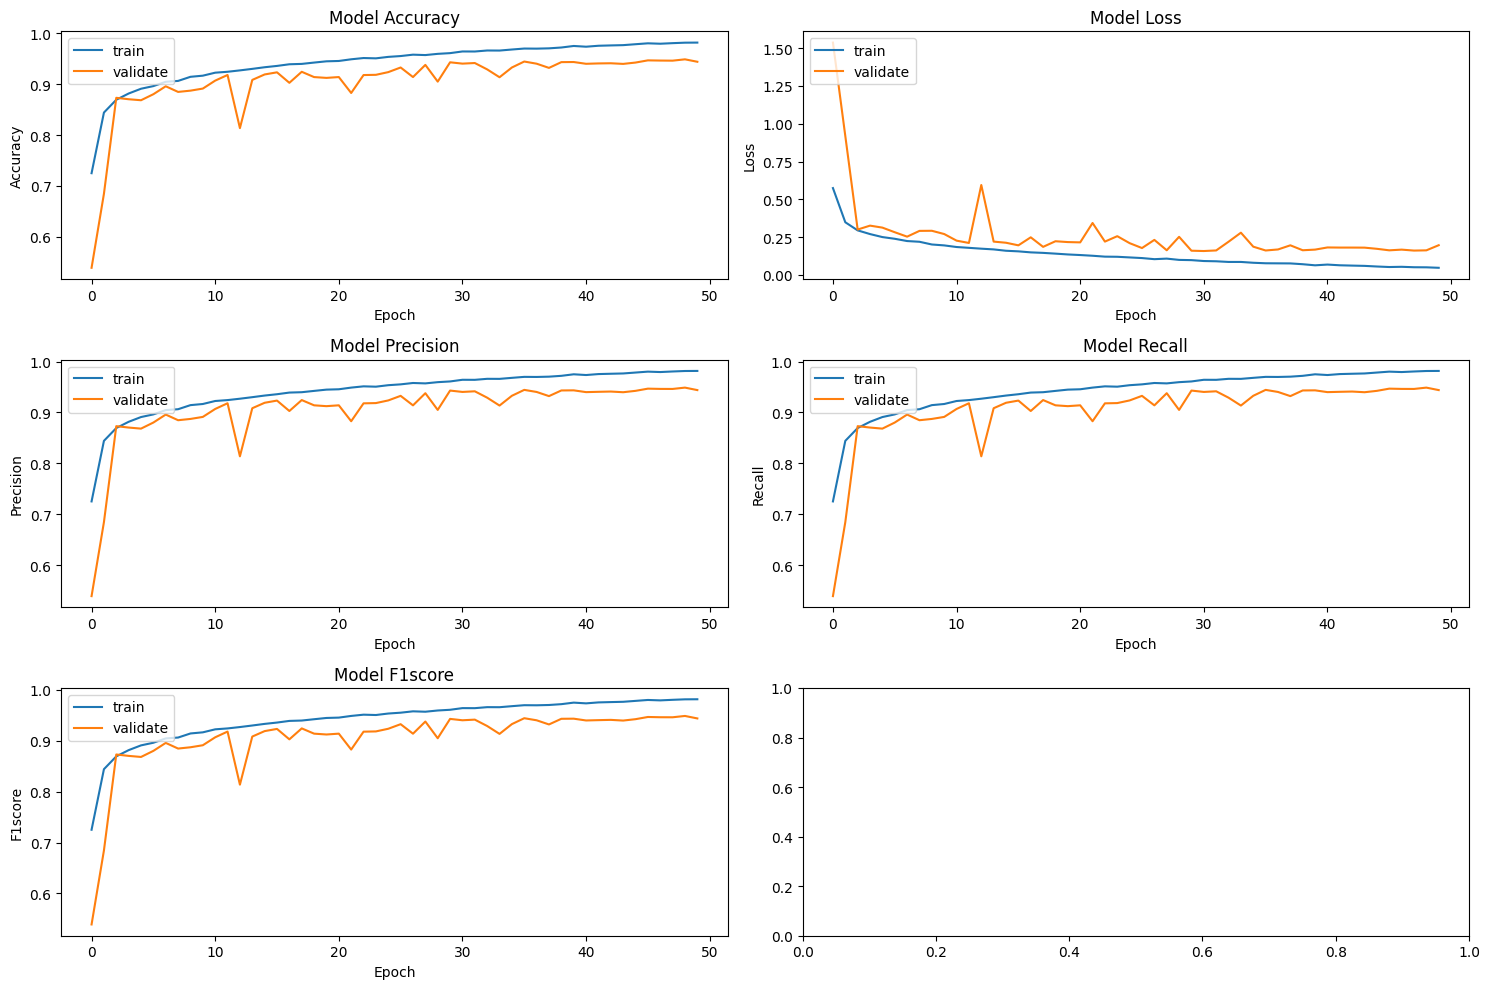

In [15]:
def plotmodelhistory(history):
    fig, axs = plt.subplots(3, 2, figsize=(15, 10))

    # Plot accuracy
    axs[0, 0].plot(history.history['accuracy'])
    axs[0, 0].plot(history.history['val_accuracy'])
    axs[0, 0].set_title('Model Accuracy')
    axs[0, 0].set_ylabel('Accuracy')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].legend(['train', 'validate'], loc='upper left')

    # Plot loss
    axs[0, 1].plot(history.history['loss'])
    axs[0, 1].plot(history.history['val_loss'])
    axs[0, 1].set_title('Model Loss')
    axs[0, 1].set_ylabel('Loss')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].legend(['train', 'validate'], loc='upper left')

    # Plot precision_m
    axs[1, 0].plot(history.history['precision_m'])
    axs[1, 0].plot(history.history['val_precision_m'])
    axs[1, 0].set_title('Model Precision')
    axs[1, 0].set_ylabel('Precision')
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].legend(['train', 'validate'], loc='upper left')

    # Plot recall_m
    axs[1, 1].plot(history.history['recall_m'])
    axs[1, 1].plot(history.history['val_recall_m'])
    axs[1, 1].set_title('Model Recall')
    axs[1, 1].set_ylabel('Recall')
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].legend(['train', 'validate'], loc='upper left')

    # Plot f1score_m
    axs[2, 0].plot(history.history['f1_m'])
    axs[2, 0].plot(history.history['val_f1_m'])
    axs[2, 0].set_title('Model F1score')
    axs[2, 0].set_ylabel('F1score')
    axs[2, 0].set_xlabel('Epoch')
    axs[2, 0].legend(['train', 'validate'], loc='upper left')

    plt.tight_layout()
    plt.show()

# list all data in history
print(history.history.keys())
plotmodelhistory(history)

In [16]:
lost_test, accuracy_test, f1score_test, precision_test, recall_test = model.evaluate(X_test, Y_test, verbose=0)
print("Loss of test set is: ",lost_test)
print("Accuracy of test set is: ",accuracy_test)
print("F1score of test set is: ",f1score_test)
print("Precision of test set is: ",precision_test)
print("Recall of test set is: ",recall_test)

Loss of test set is:  0.7501451969146729
Accuracy of test set is:  0.833837628364563
F1score of test set is:  0.833837628364563
Precision of test set is:  0.833837628364563
Recall of test set is:  0.833837628364563


### Draw confusion matrix

In [17]:
label

array(['right thumb', 'left thumb'], dtype='<U11')

In [18]:
labels = list(label)
labels

['right thumb', 'left thumb']

1911/1911 [==============================] - 10s 5ms/step


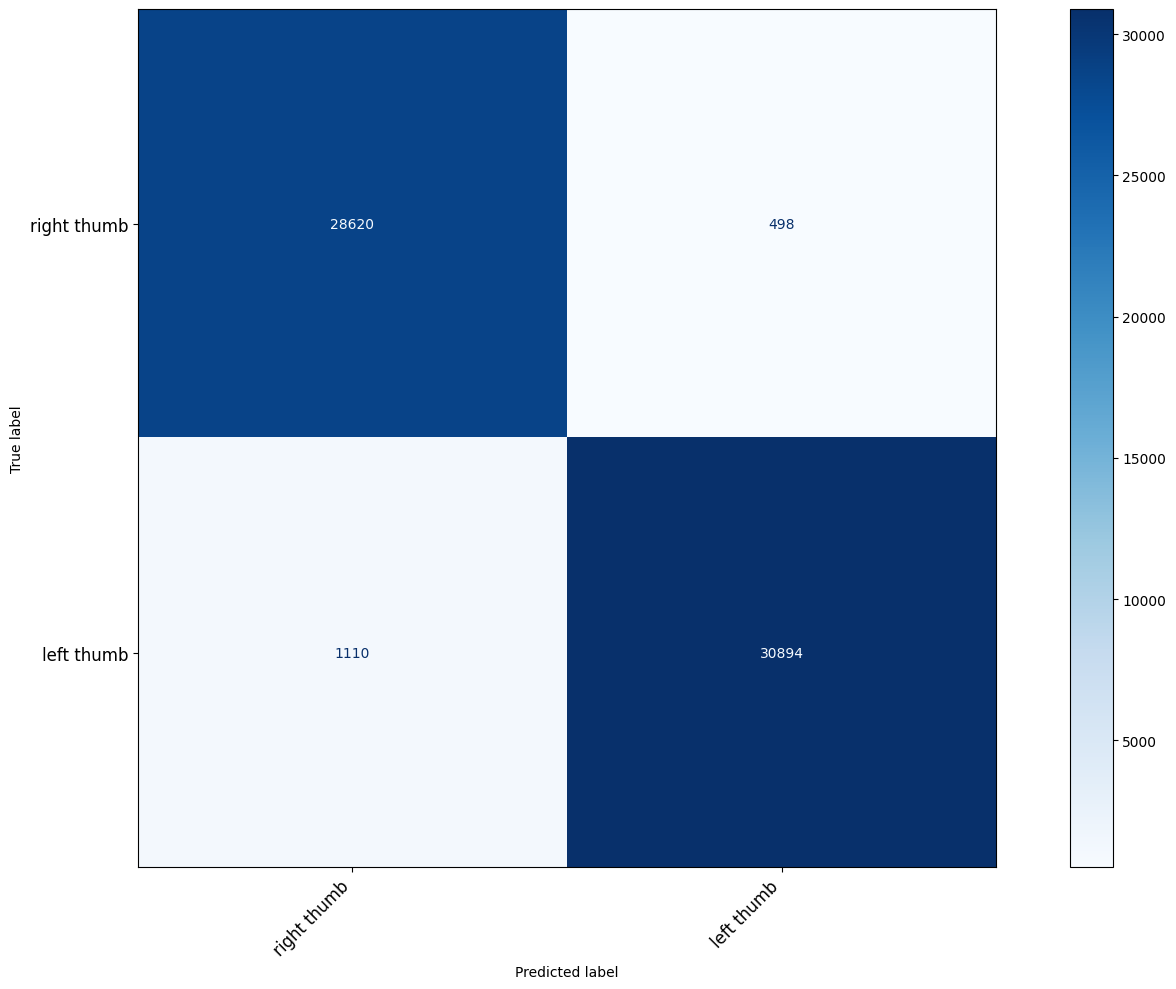

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_train)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(Y_train, axis=1)

labels = list(label)
# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(15, 10))  # resize aspect ratio

# Draw confusion matrix
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation=45)

# Downsize font of xticks
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate and downsize x-axis labels
plt.yticks(fontsize=12)  # Downsize y-axis labels

# Adjust the font size of the numbers in the cells
for text in disp.ax_.texts:
    text.set_fontsize(10)

# Use tight_layout to optimize layout
plt.tight_layout()

plt.show()


In [20]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((61122, 32, 32, 1), (61122, 2), (19168, 32, 32, 1), (19168, 2))

599/599 [==============================] - 3s 5ms/step


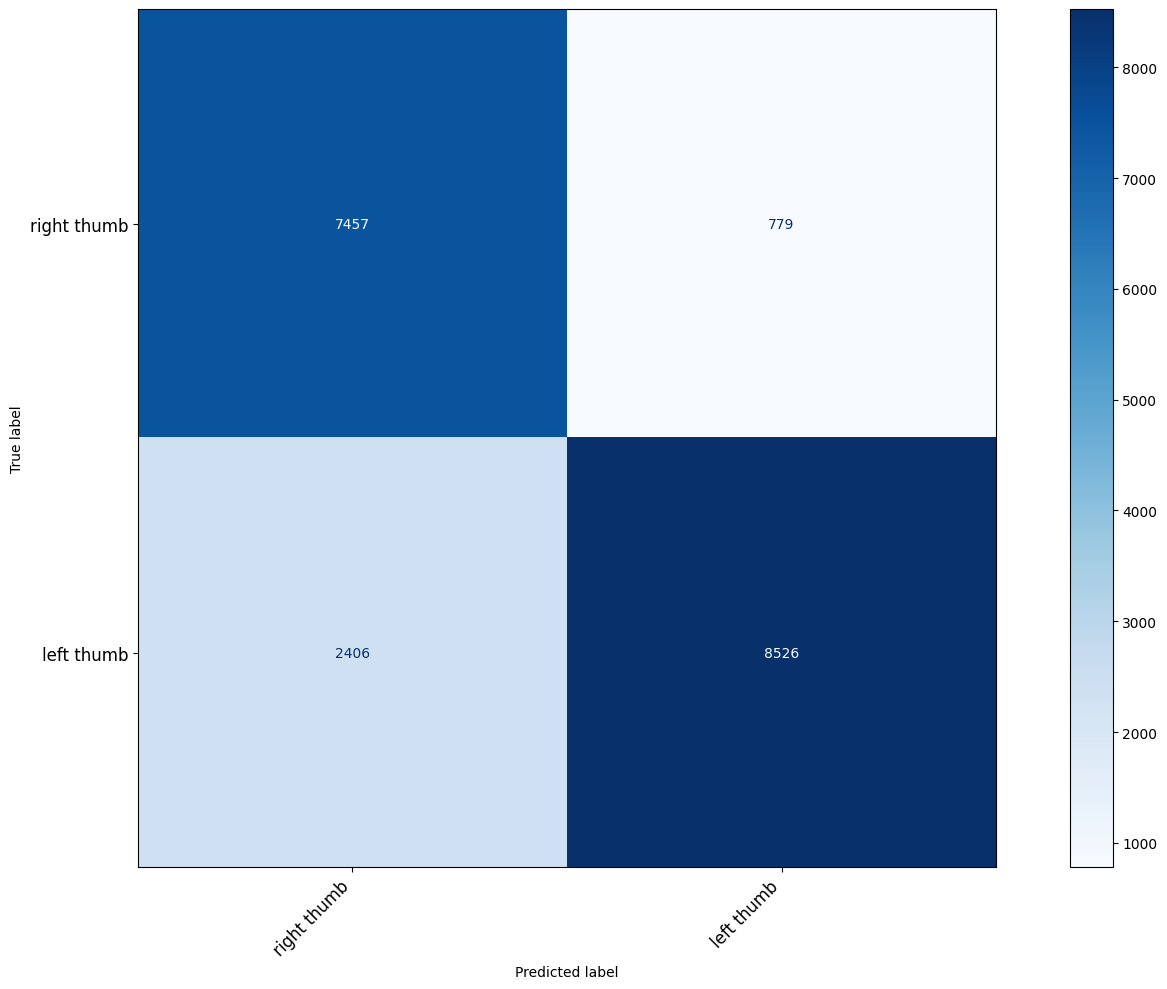

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(Y_test, axis=1)

labels = list(label)
# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(15, 10))  # resize aspect ratio

# Draw confusion matrix
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation=45)

# Downsize font of xticks
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate and downsize x-axis labels
plt.yticks(fontsize=12)  # Downsize y-axis labels

# Adjust the font size of the numbers in the cells
for text in disp.ax_.texts:
    text.set_fontsize(10)

# Use tight_layout to optimize layout
plt.tight_layout()

plt.show()
